**First of all, set environment variables and initialize spark context:**

In [1]:
from zoo.common.nncontext import *

Using /tools/spark-2.2.0-bin-hadoop2.7/
Prepending /tools/spark-2.2.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip to sys.path
Prepending /tools/spark-2.2.0-bin-hadoop2.7/python/lib/pyspark.zip to sys.path


In [2]:
# Create spark conf, you can set memory, cores, or other configuration
conf = init_spark_conf()
conf.set("spark.executor.memory", "10g")
conf.set("spark.driver.memory", "10g")

In [ ]:
# Set config for local mode and create spark context
conf.setMaster("local[*]")
sc = init_nncontext(conf)

In [3]:
# Set config to connect spark master. i.e. spark-master-1 and create spark context
# conf = init_spark_conf()
# conf.setMaster("spark-master-1")
# 
# sc = init_nncontext(conf)

# A simple neural network  example with Analytics Zoo

----

We will now take a look at a first concrete example of a neural network, which makes use of Keras (v1.2.2) API in [Analytics Zoo](https://github.com/intel-analytics/analytics-zoo) to learn to classify hand-written digits. Unless you already have experience with Keras or similar libraries, you will not understand everything about this first example right away. You probably haven't even installed Analytics zoo yet. Don't worry, that is perfectly fine. In the next chapter, we will review each element in our example and explain them in detail. So don't worry if some steps seem arbitrary or look like magic to you! We've got to start somewhere.

The problem we are trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 categories (0 to 9). The dataset we will use is the MNIST dataset, a classic dataset in the machine learning community, which has been around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. You can think of "solving" MNIST as the "Hello World" of deep learning -- it's what you do to verify that your algorithms are working as expected. As you become a machine learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.

The MNIST dataset  comes pre-loaded in the Keras API of Analytics Zoo, in the form of a set of four Numpy arrays:

#### Datasets import
_In Keras one could use following code to import the datasets:_

    from keras.datasets import mnist
_Just replace it with following in Analytics zoo:_

In [4]:
from zoo.pipeline.api.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

('Extracting', '/tmp/.zoo/dataset/mnist/train-images-idx3-ubyte.gz')
('Extracting', '/tmp/.zoo/dataset/mnist/train-labels-idx1-ubyte.gz')
('Extracting', '/tmp/.zoo/dataset/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', '/tmp/.zoo/dataset/mnist/t10k-labels-idx1-ubyte.gz')


`train_images` and `train_labels` form the "training set", the data that the model will learn from. The model will then be tested on the 
"test set", `test_images` and `test_labels`. Our images are encoded as Numpy arrays, and the labels are simply an array of digits, ranging 
from 0 to 9. There is a one-to-one correspondence between the images and the labels.

Let's have a look at the training data:

In [5]:
train_images.shape

(60000, 28, 28, 1)

In [6]:
len(train_labels)

60000

In [7]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [8]:
test_images.shape

(10000, 28, 28, 1)

In [9]:
len(test_labels)

10000

In [10]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

Our workflow will be as follow: first we will present our neural network with the training data, `train_images` and `train_labels`. The 
network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_images`, and we 
will verify if these predictions match the labels from `test_labels`.

Let's build our network -- again, remember that you aren't supposed to understand everything about this example just yet.

#### Module import
_In Keras one could use following code to import the modules we need to build the network:_

    from keras import models
    from keras import layers
_Just replace it with following in Analytics zoo:_

In [11]:
from zoo.pipeline.api.keras import models
from zoo.pipeline.api.keras import layers

In [12]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense


The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some 
data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them -- hopefully 
representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers 
which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a 
succession of increasingly refined data filters -- the "layers".

Here our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 
The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each 
score will be the probability that the current digit image belongs to one of our 10 digit classes.

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be 
able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly 
classified).

The exact purpose of the loss function and the optimizer will be made clear throughout the next two chapters.

In [13]:
network.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

creating: createRMSprop
creating: createZooKerasSparseCategoricalCrossEntropy
creating: createZooKerasSparseCategoricalAccuracy


Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in 
the `[0, 1]` interval. Previously, our training images for instance were stored in an array of shape `(60000, 28, 28)` of type `uint8` with 
values in the `[0, 255]` interval. We transform it into a `float32` array of shape `(60000, 28 * 28)` with values between 0 and 1.

In [14]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

#### Train model

We are now ready to train our network, which in Keras API of Analytics Zoo is done via a call to the `fit` method of the network: 
we "fit" the model to its training data.

In [15]:
network.fit(train_images, train_labels, nb_epoch=5, batch_size=128)

Messages below is the last INFO of training, you can find full training process in INFO, which outputs in your terminal or IDE (not the output of the program)

_INFO - Trained 128 records in 0.018066358 seconds. Throughput is 7084.992 records/second. Loss is 0.012087556._

We quickly reach an accuracy of 0.989 (i.e. 98.9%) on the training data. Now let's check that our model performs well on the test set too:

In [16]:
test_loss, test_acc = network.evaluate(test_images, test_labels, batch_size=32)
print('test_acc:', test_acc)

('test_acc:', 0.9789999723434448)


This concludes our very first example -- you just saw how we could build and a train a neural network to classify handwritten digits, in 
less than 20 lines of Python code. In the next chapter, we will go in detail over every moving piece we just previewed, and clarify what is really 
going on behind the scenes. You will learn about "tensors", the data-storing objects going into the network, about tensor operations, which 
layers are made of, and about gradient descent, which allows our network to learn from its training examples.

#### Save model

After training, save pre-trained model to local/remote path(hdfs, s3,etc.) for later use.

In [18]:
network.saveModel("/tmp/zoo.model", weightPath=None, over_write=True)

#### Load Model

Load pre-trained model for inference

In [19]:
from zoo.pipeline.api.net import *
model = Net.load("/tmp/zoo.model")

#### Prediction

Use loaded model to predict on test data

In [20]:
def map_predict_label(l):
    return np.array(l).argmax()

Populating the interactive namespace from numpy and matplotlib
Ground Truth labels:
7, 2, 1, 0, 4, 1, 4, 9
Predicted labels:
7, 2, 1, 0, 4, 1, 4, 9


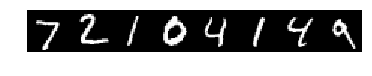

In [24]:
import matplotlib
# matplotlib.use('Agg')
%pylab inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

predictions = model.predict(test_images)
imshow(np.column_stack([s.reshape((28,28)) for s in test_images[:8]]),cmap='gray'); plt.axis('off')
print 'Ground Truth labels:'
print ', '.join(str(s) for s in test_labels[:8])
print 'Predicted labels:'
print ', '.join(str(map_predict_label(s)) for s in predictions.take(8))

In [ ]:
sc.stop()